# Example 5

## 3D case

**Content**

This notebook reproduces the first example of the paper. It consists of four main subheadings;

- Importing the *hcpinnseikonal* package functions
- Define the arguments for the input parameters
- Setup the medium and compute the data
- Training and inference

**Saving directory**

The notebook utilized [*wandb*](https://wandb.ai) for keeping track of the parameters and experiments. You can uncomment the *wandb* call to turn this feature off. Accordingly you need to specify the folder to save your experiment by changing the related *wandb* line inside the main function below.

## Import *hcpinnseikonal* package functions

In [2]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

from argparse import ArgumentParser   
from scipy import interpolate

from hcpinnseikonal.utils import *
from hcpinnseikonal.nn import *
from hcpinnseikonal.model3d import *
from hcpinnseikonal.train3d import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='n'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_fullnss2d'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriza

## Define arguments

In [3]:
args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=1000
args.seed=1234 
args.learning_rate=5e-4
args.rescale_plot='y' 
args.initial_velocity=3 
args.zid_source=1 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=12 
args.model_type='white2021' 
args.v_multiplier=6 
args.factorization_type='additive' 
args.tau_act='tanh' 
args.tau_multiplier=1 
args.max_offset=7.15253852470341
args.max_depth=1 #1.865625 
args.vertical_spacing=0.009375 
args.lateral_spacing=0.0375
args.num_neurons=24 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=50 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.2 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=10 
args.sou_spacing=30

args.plotting_factor=18.5
args.num_points=1.

args.sampling_rate=3

# args.num_layers=24
# args.num_neurons=48

dict_args=vars(args)
print(dict_args)

{'lateral_spacing': 0.0375, 'vertical_spacing': 0.009375, 'max_offset': 7.15253852470341, 'max_depth': 1, 'rec_spacing': 10, 'sou_spacing': 30, 'num_epochs': 1000, 'num_neurons': 24, 'num_layers': 12, 'learning_rate': 0.0005, 'model_type': 'white2021', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'y', 'earth_scale': 'n', 'scale_factor': 2, 'reduce_after': 50, 'seed': 1234, 'initialization': 'varianceScaling', 'plotting_factor': 18.5, 'rescale_plot': 'y', 'depth_shift': 'n', 'tau_multiplier': 1, 'initial_velocity': 3, 'zid_source': 1, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 6, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'y', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 0.2, 'event_factor': 0.9, 'checker_size': 5.0, 'tau_act': 'tanh', 'empty

## White et al. 2021 data loading

In [4]:
# Load data
velocity = pd.read_csv('../data/velocity.csv')
events = pd.read_csv('../data/events.csv')
arrivals = pd.read_csv('../data/arrivals.csv')

# Select data only down to the 18th index (16 km) according to the paper
LAT = velocity.latitude.values.reshape(251, 301, -1)[60:180,80:200,6:44]
LON = velocity.longitude.values.reshape(251, 301, -1)[60:180,80:200,6:44]
DEP = velocity.depth.values.reshape(251, 301, -1)[60:180,80:200,6:44]
VEL = velocity.Vp.values.reshape(251, 301, -1)[60:180,80:200,6:44]

# Interpolate 3-D array along the first axis (depth of the velocity model)
if args.model_type=='white2021':
    vel = np.moveaxis(np.copy(VEL), -1, 0)
    vel3d = np.empty((100, VEL.shape[0], VEL.shape[1]))
    
    for i in range(VEL.shape[0]):
        x1 = np.linspace(LON.min(), LON.max(), vel.shape[1])
        z1 = np.linspace(DEP.min(), DEP.max(), vel.shape[0]) 
        x2 = np.linspace(LON.min(), LON.max(), vel.shape[1])
        z2 = np.linspace(DEP.min(), DEP.max(), 100) 
        f = interpolate.interp2d(x1, z1, vel[:,:,i], kind='cubic')
        vel3d[:,:,i] = f(x2, z2)

## Medium setup

Cuda installed! Running on GPU!
Device: cuda:0 Quadro RTX 8000
Loading time: 2.05 minutes


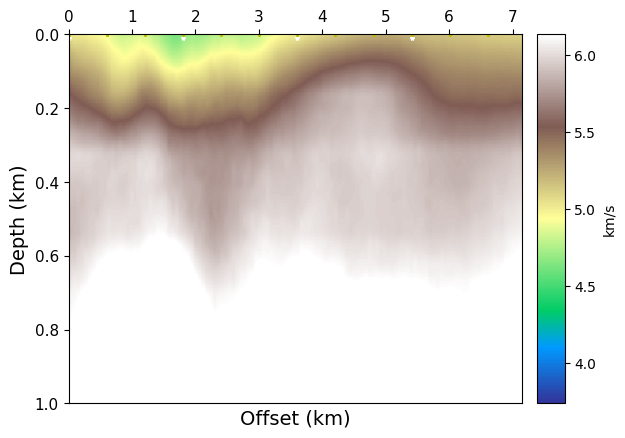

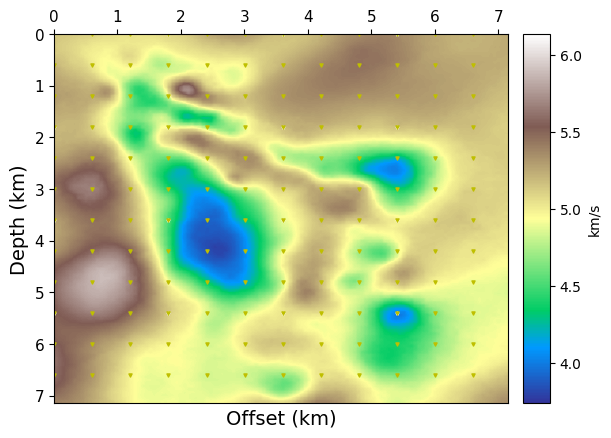

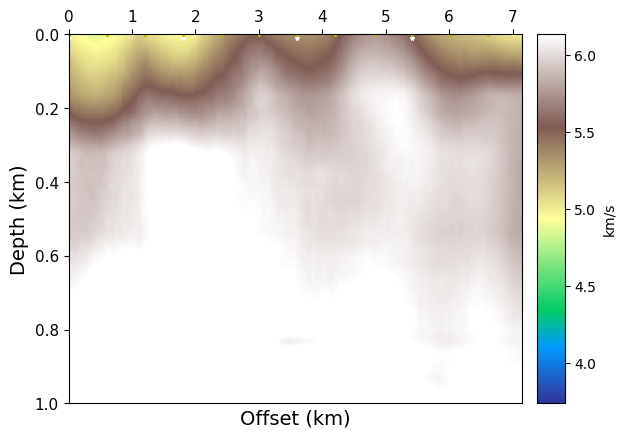

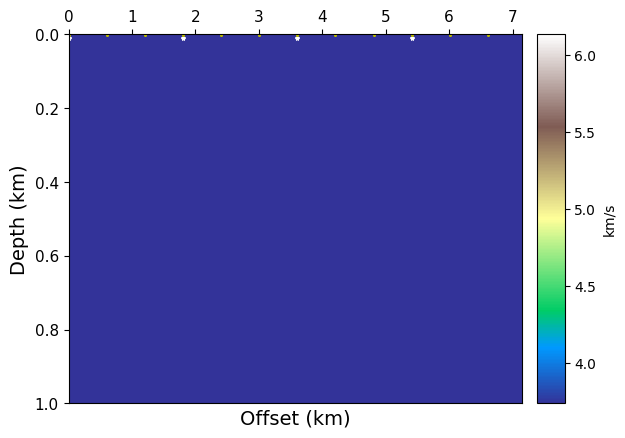

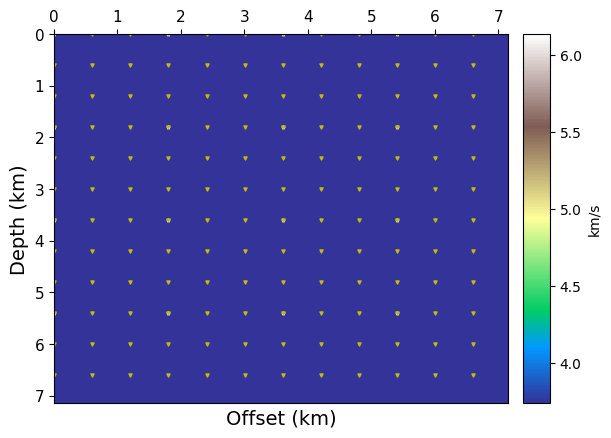

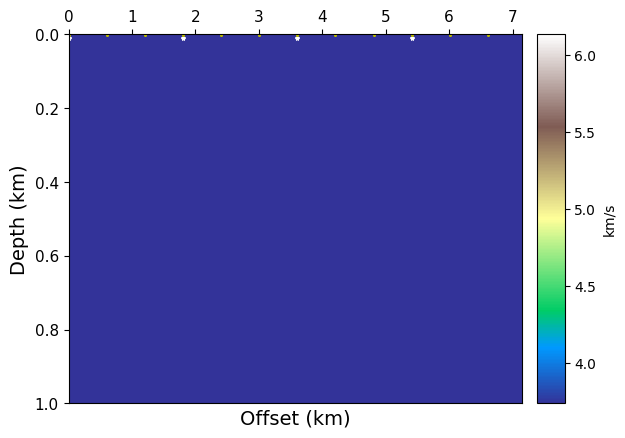

In [5]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Medium
data_type = args.data_type
deltar = args.rec_spacing
deltas = args.sou_spacing

# Computational model parameters
zmin = 0; zmax = args.max_depth; #deltaz = args.vertical_spacing;
ymin = 0.; ymax = args.max_offset; #deltay = args.lateral_spacing;
xmin = 0.; xmax = args.max_offset; #deltax = args.lateral_spacing;

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    ymin, ymax, deltay = earth_radi*ymin, earth_radi*ymax, earth_radi*deltay
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

z = np.linspace(zmin,zmax,vel3d.shape[0])
nz = z.size

y = np.linspace(ymin,ymax,vel3d.shape[2])
ny = y.size

x = np.linspace(xmin,xmax,vel3d.shape[1])
nx = x.size

Z,Y,X = np.meshgrid(z,y,x,indexing='ij')

deltax, deltay, deltaz = x[1]-x[0], y[1]-y[0], z[1]-z[0]

# Number of training points
num_tr_pts = 4000 #int(args.num_points * nz * nx)

if args.field_synthetic=='y':
    import pandas as pd
    import pygmt
    import numpy as np

    import pandas as pd

    # Earthquake events location
    location = pd.read_csv('../data/sjfzcatlog.csv')

    # Recorded traveltime data
    traveltime = pd.read_table('../data/sjfz_traveltime.dat', delim_whitespace='y')

    # Rounding to make the coordinates rounding the same
    location, traveltime = location.round(3), traveltime.round(3)

    # Merge
    data = pd.merge(traveltime, location,  how='left', left_on=['evlat','evlon','evdep'], right_on = ['evlat','evlon','evdep'])

    # Create earthquake group
    data['event_id'] = data.groupby(['evlat', 'evlon', 'evdep']).cumcount() + 1
    data['station_id'] = data.groupby(['stlat', 'stlon', 'stele']).cumcount() + 1

    # Station only
    sta_only = data.drop_duplicates(subset=['stlat', 'stlon'], keep='last')

    # Event only
    eve_only = data.drop_duplicates(subset=['evlat', 'evlon'], keep='last')

    region = [-118, -115, 32.5, 34.50]
    x0,x1,y0,y1 = -117.45, -115.55, 34.15, 32.76

    # eve_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(eve_only.event_id.values), y0*np.ones_like(eve_only.event_id.values)])
    p2=np.array([(360+x1)*np.ones_like(eve_only.event_id.values), y1*np.ones_like(eve_only.event_id.values)])
    p3=np.array([eve_only.evlon, eve_only.evlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    eve_only.loc[:, 'closest_event'] = np.copy(d[0].values)

    # sta_only['dist_to_line'] = 
    p1=np.array([(360+x0)*np.ones_like(sta_only.station_id.values), y0*np.ones_like(sta_only.station_id.values)])
    p2=np.array([(360+x1)*np.ones_like(sta_only.station_id.values), y1*np.ones_like(sta_only.station_id.values)])
    p3=np.array([sta_only.stlon, sta_only.stlat])

    d = pd.DataFrame(np.cross((p2-p1).T,(p3-p1).T)/np.linalg.norm((p2-p1).T))
    sta_only.loc[:, 'closest_station'] = np.copy(d[0].values)

    closest_sta = sta_only[np.abs(sta_only['closest_station'])<0.003]
    closest_eve = eve_only[np.abs(eve_only['closest_event'])<0.00003]

    grid = pygmt.datasets.load_earth_relief(resolution="03m", region=region)

    points = pd.DataFrame(
        data=np.linspace(start=(x0, y0), stop=(x1, y1), num=len(x)),
        columns=["x", "y"],
    )

    track = pygmt.grdtrack(points=points, grid=grid, newcolname="elevation")
    xtop = track.x.values + 360
    ztop = track.elevation.values*1e-3

    xsta = closest_sta.stlon.values
    zsta = closest_sta.stele.values

    xeve = closest_eve.evlon.values
    zeve = closest_eve.evdep.values

    xtop,xsta,xeve = xtop-xtop.min(),xsta-xsta.min(),xeve-xeve.min()
    xtop,xsta,xeve = xtop/xtop.max()*xmax,xsta/xsta.max()*xmax,xeve/xeve.max()*xmax
    
    ytop,ysta,yeve = ytop-ytop.min(),ysta-ysta.min(),yeve-yeve.min()
    ytop,ysta,yeve = ytop/ytop.max()*ymax,ysta/ysta.max()*ymax,yeve/yeve.max()*ymax

    ztop,zsta,zeve = ztop-ztop.min(),zsta-zsta.min(),zeve-zeve.min()
    ztop,zsta,zeve = args.station_factor*ztop/ztop.max()+zmin,args.station_factor*zsta/zsta.max()+zmin,zmax-args.event_factor*zeve/zeve.max()

    xsta,xeve = xsta[(xsta>xtop.min()) & (xsta<xtop.max())], xeve[(xeve>xtop.min()) & (xeve<xtop.max())]
    ysta,yeve = ysta[(ysta>ytop.min()) & (ysta<ytop.max())], yeve[(yeve>ytop.min()) & (yeve<ytop.max())]
    zsta,zeve = zsta[(xsta>xtop.min()) & (xsta<xtop.max())],zeve[(xeve>xtop.min()) & (xeve<xtop.max())]

    if args.exclude_topo=='y':
        ztop, zsta = zmin*np.ones_like(ztop), zmin*np.ones_like(zsta)

    ztop, zsta = zmin-ztop, zmin-zsta

    id_sou_z = np.array([]).astype(int)

    for szi in zeve.round(2):
        sid = np.where(np.abs(z.round(3)-szi)<1e-6)
        id_sou_z = np.append(id_sou_z,sid)

    id_rec_z = np.array([]).astype(int)

    for rzi in zsta.round(2):
        sid = np.where(np.abs(z.round(3)-rzi)<1e-6)
        id_rec_z = np.append(id_rec_z,sid)

    id_sou_y = np.array([]).astype(int)

    for syi in yeve.round(2):
        sid = np.where(np.abs(y.round(3)-syi)<1.5e-2)
        id_sou_y = np.append(id_sou_y,sid)

    id_rec_y = np.array([]).astype(int)

    for ryi in ysta.round(2):
        sid = np.where(np.abs(y.round(3)-ryi)<1.5e-2)
        id_rec_y = np.append(id_rec_y,sid)
        
    id_sou_x = np.array([]).astype(int)

    for sxi in xeve.round(2):
        sid = np.where(np.abs(x.round(3)-sxi)<1.5e-2)
        id_sou_x = np.append(id_sou_x,sid)

    id_rec_x = np.array([]).astype(int)

    for rxi in xsta.round(2):
        sid = np.where(np.abs(x.round(3)-rxi)<1.5e-2)
        id_rec_x = np.append(id_rec_x,sid)

    id_top_x = []
    id_top_y = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)
                
        for i in range(len(y)):
            if np.abs(ytop[h]-y[i])<1e-2:
                id_top_y.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    if args.regular_station=='y':
        id_rec_x = id_top_x[::args.rec_spacing]
        id_rec_y = id_top_y[::args.rec_spacing]
        id_rec_z = id_top_z[::args.rec_spacing]

    if args.append_shot=='y':
        for i in range(8):
            id_sou_x = np.append(id_sou_x, len(x)-1-2*i)
            id_sou_y = np.append(id_sou_y, len(y)-1-2*i)
            id_sou_z = np.append(id_sou_z, len(z)-1-int(0.5*i))
            
else:
    zeve, yeve, xeve = z[args.zid_source]*np.ones_like(x[::deltas]), y[::deltas], x[::deltas]
    zsta, ysta, xsta = z[args.zid_receiver]*np.ones_like(x[::deltar]), y[::deltar], x[::deltar]
    ztop, ytop, xtop = zmin*np.ones_like(x), np.copy(y), np.copy(x)

    idx_all = np.arange(X.size).reshape(X.shape)
    
    if args.model_type!='white2021':
        # Sources indices
        id_sou = idx_all[args.zid_source, ::deltas, ::deltas].reshape(-1)
    
        # Receivers indices
        id_rec = idx_all[args.zid_receiver, ::deltar, ::deltar].reshape(-1)
    else:

        # Sources indices
        id_sou = idx_all[args.zid_source, ::deltas, ::deltas].reshape(-1)
    
        # Receivers indices
        id_rec = idx_all[args.zid_receiver, ::deltar, ::deltar].reshape(-1)

# Keeping the number of shots fixed while centering the shots location
if args.middle_shot=='y':
    id_sou_left = x.shape[0]//2-len(id_sou_x)//2
    id_sou_x = np.array(range(id_sou_left, id_sou_left+len(id_sou_x)))
    id_sou_y = np.array(range(id_sou_left, id_sou_left+len(id_sou_y)))

if args.explode_reflector=='y':
    id_sou_x = np.arange(0, len(x), args.sou_spacing)
    id_sou_y = np.arange(0, len(y), args.sou_spacing)
    id_sou_z = np.ones_like(id_sou_x)*(len(z)-1)

if args.empty_middle=='y':
    id_sou, id_rec = (np.array(id_sou_x)<=(len(x)//2-50))|(np.array(id_sou_x)>=(len(x)//2+50)), (np.array(id_rec_x)<=(len(x)//2-50))|(np.array(id_rec_x)>=(len(x)//2+50))
    if args.field_synthetic=='n':
        id_sou_x = np.array(id_sou_x)[id_sou]
        id_sou_y = np.array(id_sou_y)[id_sou]
        id_sou_z = np.array(id_sou_z)[id_sou]
    id_rec_x = np.array(id_rec_x)[id_rec]
    id_rec_y = np.array(id_rec_y)[id_rec]
    id_rec_z = np.array(id_rec_z)[id_rec]

sz = Z.reshape(-1)[id_sou]
sy = Y.reshape(-1)[id_sou]
sx = X.reshape(-1)[id_sou]

Z,Y,X,SX = np.meshgrid(z,y,x,sx,indexing='ij')
_,_,_,SY = np.meshgrid(z,y,x,sy,indexing='ij')
_,_,_,SZ = np.meshgrid(z,y,x,sz,indexing='ij')
_,_,_,ID = np.meshgrid(z,y,x,np.arange(sx.size),indexing='ij')

if args.model_type=='marmousi':
    vel = np.fromfile('../data/marmousi.bin', np.float32).reshape(221, 601)
    x1 = np.linspace(0, 5, 601)
    z1 = np.linspace(0, 1, 221) 
    x2 = np.linspace(0.25, 5, len(x))
    z2 = np.linspace(0.09, 0.55, len(z)) 
    f = interpolate.interp2d(x1, z1, vel, kind='cubic')
    vel = f(x2, z2)
    # Augment a 3D velocity volume from 2D data
    vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)
elif args.model_type=='constant':
    vel = 4*np.ones((nz,nx))
elif args.model_type=='gradient':
    vel = 1 + 7*np.meshgrid(x,z)[1]
elif args.model_type=='arid':
    vel = np.fromfile('../data/seam_arid', np.float32).reshape(400,400,600)/1000
    vel3d = np.moveaxis(vel[::args.sampling_rate,::args.sampling_rate,::args.sampling_rate], -1, 0)[40:,:,:]
    
# Extending the velocity model in thirs dimension byy repeatin the array
velmodel = np.repeat(vel3d[...,np.newaxis], sx.size,axis=2)

if args.depth_shift=='y':
    zmin, zmax, z, sz, Z, SZ = zmin+5, zmax+5, z+5, sz+5, Z+5, SZ+5

X_star = [Z.reshape(-1,1), Y.reshape(-1,1), X.reshape(-1,1), SY.reshape(-1,1), SX.reshape(-1,1)] # Grid points for prediction 

# Numerical traveltime
T_data3d = numerical_traveltime3d(vel3d, len(x), len(y), len(z), len(id_sou), 
                                  xmin, ymin, zmin, deltax, deltay, deltaz, 
                                  [np.where(x==X[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(y==Y[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(z==Z[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))])

# ZX plane after
plot_section(vel3d[:,10,:], 'v_true_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# XY plane
plot_section(vel3d[5,:,:], 'v_true_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Y[:,:,:,0].reshape(-1)[id_rec])

# ZY plane
plot_section(vel3d[:,:,10], 'v_true_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=Y[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# Plots
if args.model_type=='checkerboard':
    plot_section((6 + 6.5217391304347826*Z[:,:,0])/args.scale_factor, "v_back.pdf", 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])
    plot_section(velpert[:,:,0]/args.scale_factor, "v_pert.pdf", 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

# Interpolation
Td_nn = np.zeros_like(T_data3d)
taudx_nn = np.zeros_like(T_data3d)

Ti_data = np.zeros((len(id_rec)*len(id_sou)))
xri = np.tile(X.reshape(-1)[id_rec], len(id_sou))
yri = np.tile(Y.reshape(-1)[id_rec], len(id_sou))
zri = np.tile(Z.reshape(-1)[id_rec], len(id_sou))

xsi = np.repeat(X.reshape(-1)[id_sou], len(id_rec))
ysi = np.repeat(Y.reshape(-1)[id_sou], len(id_rec))
zsi = np.repeat(Z.reshape(-1)[id_sou], len(id_rec))

for i in range(len(id_sou)):
    Ti_data[i*len(id_rec):(i+1)*len(id_rec)] = T_data3d[:,:,:,i].reshape(-1)[id_rec]
    
rand_idx = np.random.permutation(np.arange(len(Ti_data)))

X_ori = np.vstack((xri, yri, zri, xsi, ysi, zsi)).T
y_ori = Ti_data

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

if data_type=='nn':
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(6, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(5e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn = np.zeros_like(T_data3d)
    
    if args.field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx)), 
                 np.tile(y, len(sy)),
                 np.tile(z[args.zid_receiver]*np.ones_like(x), len(sz)), 
                 np.repeat(x[id_sou_x], len(x)), 
                 np.repeat(y[id_sou_y], len(y)), 
                 np.repeat(z[id_sou_z], len(z))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou)):
        Td_nn[:,:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join(wandb_dir, "data_loss.pdf"), format='pdf', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, wandb_dir+'/saved_data_model')

# Analytical solution for the known traveltime part
if args.depth_shift=='y':
    vs = args.initial_velocity #velmodel[np.round((SZ-5)/deltaz).astype(int),np.round(SX/deltax).astype(int),0]
else:
    vs = 5#vel3d[np.round(SZ/deltaz).astype(int),np.round(SY/deltay).astype(int),np.round(SX/deltax).astype(int)]

T0 = np.sqrt((Z-SZ)**2 + (Y-SY)**2 + (X-SX)**2)/vs;
px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
py0 = np.divide(Y-SY, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

if args.field_synthetic=='y':
    xf = np.arange(xmin,xmax+0.1*deltax,0.1*deltax)
    zf = np.arange(zmin,zmax+0.1*deltaz,0.1*deltaz)
    T_topo = np.zeros((len(zf), len(xf), len(id_sou_x)))
    for i in range(len(id_sou_x)):
        f = interpolate.interp2d(x, z, T_data3d[:,:,i], kind='cubic')
        T_topo[:,:,i] = f(xf, zf)
    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    taud_topo = np.divide(T_data3d, T0, where=T0!=0)[id_top_z, id_top_x, :]
    T_topo = T_data[id_top_z, id_top_x, :]

    taud_topo = np.repeat(taud_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)
    T_topo = np.repeat(T_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)

Td_hc = np.zeros_like(T0)
T0_hc = np.zeros_like(T0)
taud_hc = np.zeros_like(T0)
taudx_hc = np.zeros_like(T0)
taudy_hc = np.zeros_like(T0)

for i in range(len(id_sou)):
    T0_hc[:,:,:,i] = np.moveaxis(np.tile(T0.reshape(X.shape)[args.zid_receiver,:,:,i], nz).reshape(ny,nz,nx), 1, 0)
    # np.tile(T0[args.zid_receiver,:,:,i], nz).reshape(nz,ny,nx)

    # Numerical
    if data_type=='full':
        Td_hc[:,:,:,i] = np.moveaxis(np.tile(T_data3d[args.zid_receiver,:,:,i], nz).reshape(ny,nz,nx), 1, 0)
    # np.tile(T_data3d[args.zid_receiver,:,:,i], nz).reshape(nz,ny,nx)

    # NN-based interpolation
    elif data_type=='nn':
        Td_hc[:,:,:,i] = Td_nn[:,:,:,i].reshape(nz,ny,nx)

    if args.factorization_type=='multiplicative':   
        taud_hc[:,:,:,i] = np.divide(Td_hc[:,:,:,i], T0_hc[:,:,:,i], out=np.ones_like(T0_hc[:,:,:,i]),
                                   where=T0_hc[:,:,:,i]!=0)
    else:
        taud_hc[:,:,:,i] = Td_hc[:,:,:,i] - T0_hc[:,:,:,i]

    # Numerical
    if data_type=='full':
        taudy_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltay, axis=1)
        taudx_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltax, axis=2)

    # NN-based interpolation
    elif data_type=='nn':
        taudy_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltay, axis=1)        
        taudx_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltax, axis=2)

if args.field_synthetic=='y':

    NAN = np.ones_like(X)
    for i in range(z.shape[0]):
        for j in range(x.shape[0]):
            if z[i] < Z[id_top_z, id_top_x, 0][j]:
                NAN[i,j,:] = float("Nan")
                
# Locate source boolean
import time
start_time = time.time()

sids = id_sou

# Locate source boolean
isource = np.ones_like(X_star[0]).reshape(-1,).astype(bool)
isource[sids] = False

velmodel = vel3d.reshape(-1,1)
px0 = px0.reshape(-1,1)
py0 = py0.reshape(-1,1)
pz0 = pz0.reshape(-1,1)
T0 = T0.reshape(-1,1)
T_data = T_data3d.reshape(-1,1)
taud = taud_hc.reshape(-1,1)

if args.factorization_type=='multiplicative':
    taud[~isource] = 1.    
taudx = taudx_hc.reshape(-1,1)
taudy = taudy_hc.reshape(-1,1)
index = ID.reshape(-1,1)

perm_id = np.random.permutation(X.size-sx.size)

input_wsrc = [X, Y, Z, SX+len(id_sou), SY+len(id_sou), SZ+len(id_sou), taud, taudx, taudy, T0, px0, py0, pz0, index]
input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]
if args.field_synthetic=='y':
    input_wonan = [i.ravel()[~np.isnan(NAN.ravel()[isource.reshape(-1)][perm_id])] for i in input_wosrc]

# Network
lay = 'linear'
ini = args.initialization
bias = 0.2
mean = 0.01
std = 0.05
opttype = 'adam'
lr = args.learning_rate

torch.manual_seed(seed)
if args.residual_network=='n':
    tau_model = FullyConnectedNetwork(6, 1, [args.num_neurons]*args.num_layers, last_act=args.tau_act, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
else:
    tau_model = ResidualNetwork(6, 1, num_neurons=args.num_neurons, num_layers=args.num_layers, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
tau_model.to(device)

torch.manual_seed(seed)
if args.residual_network=='n':
    v_model = FullyConnectedNetwork(3, 1, [args.num_neurons//2]*args.num_layers, act=args.activation, lay=lay, last_act='relu', last_multiplier=args.v_multiplier)
else:
    v_model = ResidualNetwork(3, 1, num_neurons=args.num_neurons//2, act='relu', last_act='relu', num_layers=args.num_layers, lay=lay, last_multiplier=args.v_multiplier)
v_model.to(device)
v_model.apply(lambda m: init_weights(m, init_type=ini, bias=bias, mean=mean, std=std))

perc = args.num_points

if args.irregular_grid=='y':
    npoints = int(X.size * perc)
    ipermute = np.random.permutation(np.arange(X.size))[:npoints]
else:
    ipermute = None

# Compute traveltime with randomly initialized network
pde_loader, ic = create_dataloader3d([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048//8, fast_loader=True, perm_id=ipermute)

if args.exp_function=='y':
    rec_op = (1-np.exp((Z.reshape(X.shape)-z[args.zid_receiver])**args.exp_factor))
else:
    rec_op = Z.reshape(X.shape)

v_init = evaluate_velocity3d(v_model, pde_loader, X.size, batch_size=2048//8, device=device).detach().cpu().numpy().reshape(X.shape)

elapsed = time.time() - start_time
print('Loading time: %.2f minutes' %(elapsed/60.))

# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(list(tau_model.parameters()) + list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()) + list(v_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=args.reduce_after, verbose=True)

# ZX plane after
plot_section(v_init.reshape(X.shape)[:,10,:,0], 'v_init_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# XY plane
plot_section(v_init.reshape(X.shape)[5,:,:,0], 'v_init_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Y[:,:,:,0].reshape(-1)[id_rec])

# ZY plane
plot_section(v_init.reshape(X.shape)[:,:,10,0], 'v_init_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=Y[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

## Training and Inference

In [ ]:
# Training
import time
start_time = time.time()
if args.field_synthetic=='y':
    loss_history = \
        training_loop3d(
            input_wonan, sx, sy, sz,
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//2000, device=device, scheduler=scheduler,
            fast_loader=True, args=dict_args
    ) 
else:
    loss_history = \
        training_loop3d(
            input_wosrc, sx, sy, sz,
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//2000, device=device, scheduler=scheduler, 
            fast_loader=True, args=dict_args
    )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);212
plt.grid()
plt.savefig(os.path.join(wandb_dir, "loss.pdf"), format='pdf', bbox_inches="tight")

# Prediction
pde_loader, ic = create_dataloader3d([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048, fast_loader=True, perm_id=ipermute)
v_pred = evaluate_velocity3d(v_model, pde_loader)

tau_pred = evaluate_tau3d(tau_model, pde_loader)

v_pred = v_pred.detach().cpu().numpy()
tau_pred = tau_pred.detach().cpu().numpy()

# ZX plane after
plot_section(v_pred.reshape(X.shape)[:,0,:,i], 'v_pred_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

# XY plane
plot_section(v_pred.reshape(X.shape)[args.zid_source,:,:,i], 'v_pred_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Y[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Y[:,:,:,i].reshape(-1)[id_rec])

# ZY plane
plot_section(v_pred.reshape(X.shape)[:,:,0,i], 'v_pred_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=Y[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

# Save model
torch.save({
        'tau_model_state_dict': tau_model.state_dict(),
        'v_model_state_dict': v_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_history
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Prediction
pde_loader, ic = create_dataloader3d([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048, fast_loader=True, perm_id=ipermute)
v_pred = evaluate_velocity3d(v_model, pde_loader, X.size, batch_size=2048, device=device)

tau_pred = evaluate_tau3d(tau_model, pde_loader, X.size, batch_size=2048, device=device)

v_pred = v_pred.detach().cpu().numpy()
tau_pred = tau_pred.detach().cpu().numpy()

# ZX plane after
plot_section(v_pred.reshape(X.shape)[:,10,:,i], 'v_pred_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

# XY plane
plot_section(v_pred.reshape(X.shape)[5,:,:,i], 'v_pred_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Y[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Y[:,:,:,i].reshape(-1)[id_rec])

# ZY plane
plot_section(v_pred.reshape(X.shape)[:,:,10,i], 'v_pred_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=Y[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

print(y[30])
for i in range(len(x)):
    if i%10==0:
        plot_trace(v_init[:,:,30,0], vel3d[:,:,30], v_pred.reshape(X.shape)[:,:,30,0], i, x, z, 
                   fig_name='trace_x_'+str(round(x[i], 2))+'.pdf', save_dir=wandb_dir)
        
print(x[20])
for i in range(len(y)):
    if i%10==0:
        plot_trace(v_init[:,20,:,0], vel3d[:,20,:], v_pred.reshape(X.shape)[:,20,:,0], i, x, z, 
                   fig_name='trace_y_'+str(round(y[i], 2))+'.pdf', save_dir=wandb_dir)

Epoch 0, Loss 0.0045181
Epoch 3, Loss 0.0000180
Epoch 6, Loss 0.0000168
Epoch 9, Loss 0.0000281
